# Final Project: Risk factors for Coronary Heart Disease 

Dataset downloaded from Kaggle example [Behavioral Risk Factor Surveillance System](https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data)

 - Load libraries
 - Get data from Kaggle
 - Data cleaning
    - Variable selection 




In [1]:
# Install required packages
%pip install -r requirements.txt
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Libraries
import zipfile
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from ydata_profiling import ProfileReport
from sqlalchemy import create_engine

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Unzip the data
with zipfile.ZipFile('BRFSS.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [4]:
# Load each CSV into a DataFrame
tables = []
for f in os.listdir('data'):
    if f.endswith('.csv'):
        table_name = 'df'+f.replace('.csv', '')
        file_path = os.path.join('data', f)
        # tables[table_name] = pd.read_csv(file_path)
        tables.append(table_name)
        globals()[table_name] = pd.read_csv(file_path)

KeyboardInterrupt: 

In [ ]:
# Load json mapping file into a dictionary
import json
with open('data/2015_formats.json', 'r') as file: 
    mapping = json.load(file)
# Example: codebook for 'CVD4CRHD' ('CVDCRHD4' in .csv file)
    # Note: variable codes in codebook and .csv files may not be the same
mapping['CVD4CRHD']

{'.': '"Not asked or Missing"',
 '.D': '"DK/NS"',
 '.R': '"REFUSED"',
 '1': '"Yes"',
 '2': '"No"',
 '7': '"Don\x92t know/Not sure"',
 '9': '"Refused"'}

## Exploratory data analysis
(of BRFSS 2015 data)

In [ ]:
print(f'There are {df2015.shape[0]} rows and {df2015.shape[1]} columns in the original data set.')

There are 441456 rows and 330 columns in the original data set.


### Select target and predictor variables

In [ ]:
# Create dictionary to store variables and their corresponding BRFSS code 
varname_code_mapping = {
    # target variable
    'chd': 'CVDCRHD4', 
    # predictor variables
        #demographic variables
    'sex': 'SEX', 
    'race': '_RACE_G1',
    'age5y': '_AGEG5YR',  
    'ever_married': 'MARITAL',
        #socioeconomic status variables
    'education':'_EDUCAG', 
    'income': '_INCOMG',
    'employment': 'EMPLOY1', 
        # health variables
    'diabetes': 'DIABETE3', 
    'hypertension': 'BPHIGH4', 
    'bmi': '_BMI5',
        # behavioral variables
    'smoke': '_SMOKER3',
    'vegetable': '_VEGLT1',
    'fruit': '_FRTLT1',
    'binge_drink': 'DRNK3GE5',
    'exercise': 'EXERANY2', 
}


In [ ]:
# Take data from 2015 BFRSS data frame
df = df2015

# Record numerical variables
numerical_variables = ['bmi', 'binge_drink']

# Select variables and store in new data frame
    # Catagorical variables are stored as strings
    # Numerical variables are transformed as needed when imported
dirty_df = pd.DataFrame()
for key, code in varname_code_mapping.items(): 
    if key not in numerical_variables: 
        dirty_df[key] = df[code]
    elif key == 'bmi':
        # Return true values of bmi (divide by 100)
        dirty_df[key] = df[code]/100
    elif key == 'binge_drink': 
        dirty_df[key] = df[code].replace({88: 0, 77: np.nan, 99: np.nan})
    


In [ ]:
print(f'There are {dirty_df.shape[0]} rows and {dirty_df.shape[1]} columns in the selected data set.')

There are 441456 rows and 16 columns in the selected data set.


In [ ]:
# Print overview of numerical variables
dirty_df[numerical_variables].describe()

,bmi,binge_drink
count,405058.000000,207385.000000
mean,28.042424,1.051908
std,6.654634,3.573428
min,12.020000,0.000000
25%,23.730000,0.000000
50%,26.950000,0.000000
75%,30.900000,0.000000
max,99.950000,76.000000


## Clean Data

#### - Remove unrealistic data (BMI>= 18.5)

In [ ]:
# BMI is unlikely to be lower than 18.5
dirty_df = dirty_df[dirty_df['bmi'] >= 18.5]

#### - Recode variables

In [ ]:
# Check unique codes of binary variables and print out 
# Collect binary variables need to be recoded 
binary_var = ['chd', 'sex', 'ever_married', 'diabetes', 'hypertension', 'vegetable', 'fruit', 'exercise']
recode_binary_var = []
for var in binary_var: 
    print(var)
    print(dirty_df[var].unique())
    if len(dirty_df[var].unique())>2: 
        recode_binary_var.append(var)
print(f"Binary variables that need to be recoded: {recode_binary_var}")

chd
[ 2.  1.  7.  9. nan]
sex
[2. 1.]
ever_married
[1. 2. 3. 6. 5. 4. 9.]
diabetes
[ 3.  1.  4.  2.  7. nan  9.]
hypertension
[ 1.  3.  7.  2.  4.  9. nan]
vegetable
[1. 2. 9.]
fruit
[2. 9. 1.]
exercise
[ 2.  1. nan  9.  7.]
Binary variables that need to be recoded: ['chd', 'ever_married', 'diabetes', 'hypertension', 'vegetable', 'fruit', 'exercise']


In [ ]:
"""
Recode instructions 
Codes for 'hypertension' and 'diabetes'
 '1': "Yes"
 '2': '"Yes, but female told only during pregnancy"' -> np.nan
 '3': '"No"' -> '0'
 '4': '"Told borderline high or pre-condition"' -> np.nan
 '7': '"Don't know/Not Sure"' -> np.nan
 '9': '"Refused"' --> np.nan
"""
# Recode variables ['hypertension', 'diabetes'] into binary variables
vars = ['hypertension', 'diabetes']
for col in vars: 
    dirty_df[col]= dirty_df[col].replace({2.: np.nan, 3.: 0,  4.: np.nan, 
                                          7.: np.nan, 9.: np.nan})

"""
Codes for 'vegetable' and 'fruit'
 '1': '"Consumed one or more times per day"' 
 '2': '"Consumed less than one time per day"' -> 0
 '9': '"Don´t know, refused or missing values" -> np.nan

Codes for 'exercise' and 'chd'
 '1': '"Yes"'
 '2': '"No"' -> 0
 '7': '"Don't know/Not sure"'-> np.nan
 '9': '"Refused"' -> np.nan


"""
# Recode variables ['vegetable', 'fruit', 'exercise'] into binary variables
vars = ['chd', 'vegetable', 'fruit', 'exercise']
for col in vars: 
    dirty_df[col]= dirty_df[col].replace({2.: 0, 7.: np.nan, 9.: np.nan})


"""
Codes for 'ever_married'
 '1': '"Married"' -> 1
 '2': '"Divorced"' -> 1
 '3': '"Widowed"' -> 1
 '4': '"Separated"' -> 1
 '5': '"Never married"' -> 0
 '6': '"A member of an unmarried couple"' -> 0
 '9': '"Refused"' -> np.nan
"""

# Recode 'ever_married' as binary variable (0 = No, 1 = Yes)

dirty_df['ever_married'] = dirty_df['ever_married'].replace({1.: 1, 2.: 1, 3.: 1, 4.: 1, 
                                                             5.: 0, 6.: 0, 
                                                             9.: np.nan})


"""
Codes for 'age5y'
 '1': '"Age 18 to 24"',
 '2': '"Age 25 to 29"',
 '3': '"Age 30 to 34"',
 '4': '"Age 35 to 39"',
 '5': '"Age 40 to 44"',
 '6': '"Age 45 to 49"',
 '7': '"Age 50 to 54"',
 '8': '"Age 55 to 59"',
 '9': '"Age 60 to 64"',
 '10': '"Age 65 to 69"',
 '11': '"Age 70 to 74"',
 '12': '"Age 75 to 79"',
 '13': '"Age 80 or older"',
 '14': '"Don't know/Refused/Missing" -> np.nan
"""
dirty_df['age5y'] = dirty_df['age5y'].replace({14.: np.nan})

"""
Codes for 'education'
 '1': '"Did not graduate High School"',
 '2': '"Graduated High School"',
 '3': '"Attended College or Technical School"',
 '4': '"Graduated from College or Technical School"',
 '9': '"Don't know/Not sure/Missing"-> np.nan

Codes for 'income'
 '1': '"Less than $15,000"',
 '2': '"$15,000 to less than $25,000"',
 '3': '"$25,000 to less than $35,000"',
 '4': '"$35,000 to less than $50,000"',
 '5': '"$50,000 or more"',
 '9': '"Don't know/Not sure/Missing"'-> np.nan
"""
vars = ['education', 'income']
for col in vars: 
    dirty_df[col]= dirty_df[col].replace({9.: np.nan})

"""" 
Codes for 'employment':
 '1': '"Employed for wages"'
 '2': '"Self-employed"'
 '3': '"Out of work for 1 year or more"'
 '4': '"Out of work for less than 1 year"'
 '5': '"A homemaker"'
 '6': '"A student"'
 '7': '"Retired"'
 '8': '"Unable to work"' -> np.nan (exclude since those unable to work)
 '9': '"Refused"' -> np.nan

 Note: Those unable to work are excluded since there is a high possibility that they may have other health conditions. 
"""

dirty_df['employment'] = dirty_df['employment'].replace({8.:np.nan, 9.: np.nan})

"""
Codes for 'smoke':
 '1': '"Current smoker - now smokes every day"',
 '2': '"Current smoker - now smokes some days"' --> '1'
 '3': '"Former smoker"', -> '2'
 '4': '"Never smoked"', --> '0'
 '9': '"Don't know/Refused/Missing"' -> np.nan
"""
# Recode 'smoke' into 3 catagories (1 = current smoker, 2 = never smoked, 3 = former smoker)

dirty_df['smoke'] = dirty_df['smoke'].replace({2.:1, 3.: 2, 4.: 0, 9.: np.nan})


#### - Verify that variables are correctly recoded

In [ ]:
# Check all levels are correctly assigned to new levels

for key, code in varname_code_mapping.items(): 
    if key not in numerical_variables: 
        print(pd.crosstab(dirty_df[key],df2015[code]))

CVDCRHD4    1.0     2.0
chd                    
0.0           0  371378
1.0       23624       0
SEX     1.0     2.0
sex                
1.0  177417       0
2.0       0  220920
_RACE_G1     1.0    2.0    3.0    4.0   5.0
race                                       
1.0       306085      0      0      0     0
2.0            0  30852      0      0     0
3.0            0      0  31021      0     0
4.0            0      0      0  17391     0
5.0            0      0      0      0  7485
_AGEG5YR   1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0   \
age5y                                                                     
1.0       21182      0      0      0      0      0      0      0      0   
2.0           0  17360      0      0      0      0      0      0      0   
3.0           0      0  20168      0      0      0      0      0      0   
4.0           0      0      0  21986      0      0      0      0      0   
5.0           0      0      0      0  23524      0      0      0  

In [ ]:
# Save cleaned data 
clean_df = dirty_df.dropna()
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 146381 entries, 6 to 441450
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   chd           146381 non-null  float64
 1   sex           146381 non-null  float64
 2   race          146381 non-null  float64
 3   age5y         146381 non-null  float64
 4   ever_married  146381 non-null  float64
 5   education     146381 non-null  float64
 6   income        146381 non-null  float64
 7   employment    146381 non-null  float64
 8   diabetes      146381 non-null  float64
 9   hypertension  146381 non-null  float64
 10  bmi           146381 non-null  float64
 11  smoke         146381 non-null  float64
 12  vegetable     146381 non-null  float64
 13  fruit         146381 non-null  float64
 14  binge_drink   146381 non-null  float64
 15  exercise      146381 non-null  float64
dtypes: float64(16)
memory usage: 19.0 MB


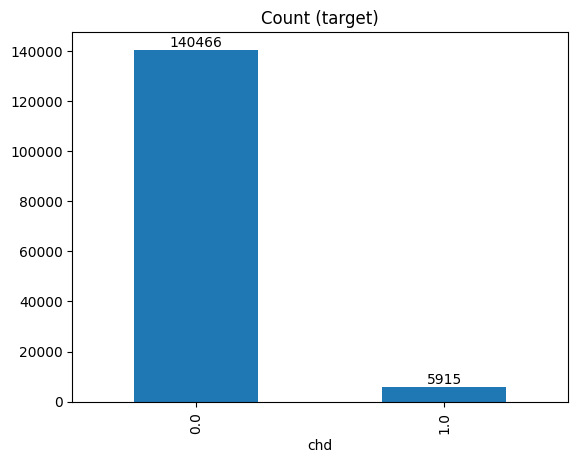

In [ ]:
target_count= clean_df.chd.value_counts()
target_count.plot(kind='bar', title='Count (target)')
for i, count in enumerate(target_count):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

In [ ]:
clean_df.to_csv('cleaned_data_imbalanced.csv', index=False)

In [20]:
# ydata-profiling report of dirty data file
from IPython.core.display import display
profile = ProfileReport(clean_df, title = "Profile Report")
profile.to_widgets()

ImportError: cannot import name 'display' from 'IPython.core.display' (/Users/Daphne/Library/Python/3.11/lib/python/site-packages/IPython/core/display.py)

## (Optional) Random downsampling

Imbalance of data is observed in the between those diagnosed with angina or coronary heart disease (`chd`=1) and those who were not (`chd`=0). Random sampling was done to balance the number of samples in two groups. 

In [ ]:
# Class count
count_class_0, count_class_1 = clean_df.chd.value_counts()

# Divide by class
df_chd0 = clean_df[clean_df['chd'] == 0.]
df_chd1 = clean_df[clean_df['chd'] == 1.]

# Under sampling
df_chd0_under = df_chd0.sample(count_class_1)
cleandf_undersample = pd.concat([df_chd0_under, df_chd1], axis=0)

cleandf_undersample.chd.value_counts().plot(kind='bar', title='Count (target)')
for i, count in enumerate(cleandf_undersample.chd.value_counts()):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')
plt.show()


In [ ]:
for var in varname_code_mapping.keys(): 
    if var not in numerical_variables:
        print(pd.crosstab(cleandf_undersample['chd'],cleandf_undersample[var]))


In [ ]:
# ydata-profiling report of clean & downsampled data file
profile = ProfileReport(cleandf_undersample, title = "Profile Report")
profile.to_widgets()

In [ ]:
cleandf_undersample.to_csv('cleaned_data.csv')